# Welcome to the EEweather Tutorial

This tutorial is pretty minimal for now, but it demonstrates loading and using eeweather for the simple task of finding a nearby weather station (using lat/long coordinates) and loading temperature data for that station.

In [1]:
# show plots in notebook
%matplotlib inline

# allows making edits to code
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import json

import matplotlib.pyplot as plt
import pytz

import eeweather

In [3]:
%%javascript
/* 
   OPTIONAL - Run this to get your approximate coordinates for use below.
   Uses your browser's IP and a free external service.
*/
var xhr = new XMLHttpRequest();
xhr.open('GET', '//freegeoip.net/json/');
xhr.onload = function() {
    if (xhr.status === 200) {
        var output = JSON.parse(xhr.responseText);
        element.text('Your (very roughly approximate) coordinates: (' + output.latitude + ', '+ output.longitude + ')');
    }
};
xhr.send();

<IPython.core.display.Javascript object>

In [27]:
# convert ZCTA to coordinates
lat, long = eeweather.zcta_to_lat_long(90210)
lat, long

(34.1010279124639, -118.414760978568)

In [28]:
# default coordinates are in downtown Los Angeles
lat, long = (34.0522, -118.2437)

In [29]:
# returned result is an object
result = eeweather.match_lat_long(lat, long)
result

ISDStationMapping('722880', distance_meters=19585)

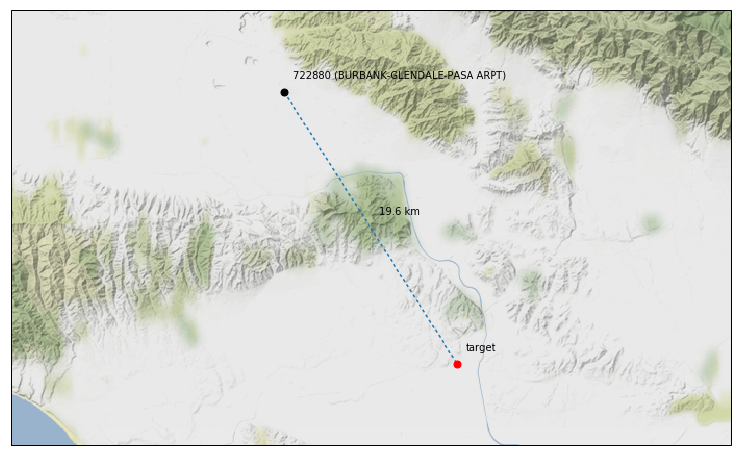

In [18]:
# plot match
result.plot()

In [19]:
# get match distance
result.distance_meters

19585

In [20]:
# get station object from result
station = result.isd_station
station

ISDStation('722880')

In [21]:
# view station data
print(json.dumps(station.json(), indent=2))

{
  "elevation": 236.2,
  "latitude": 34.201,
  "longitude": -118.358,
  "icao_code": "KBUR",
  "name": "BURBANK-GLENDALE-PASA ARPT",
  "quality": "high",
  "wban_ids": [
    "23152",
    "99999"
  ],
  "recent_wban_id": "23152",
  "climate_zones": {
    "iecc_climate_zone": "3",
    "iecc_moisture_regime": "B",
    "ba_climate_zone": "Hot-Dry",
    "ca_climate_zone": "CA_09"
  }
}


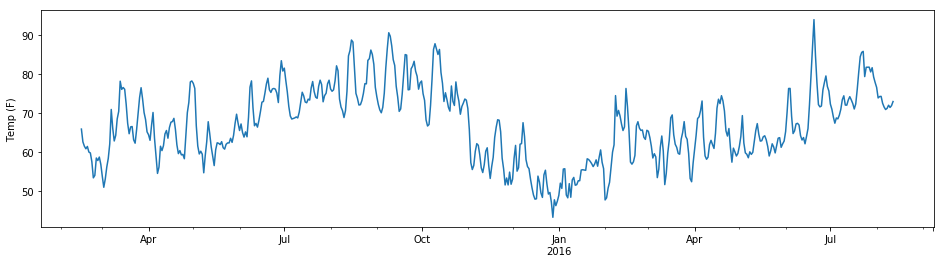

In [22]:
# pull temperature data over a range - make sure to use tz-aware datetimes!
start = datetime.datetime(2015, 2, 15, tzinfo=pytz.UTC)
end = datetime.datetime(2016, 8, 12, tzinfo=pytz.UTC)
temp_C = station.load_isd_daily_temp_data(start, end)
temp_F = temp_C * 1.8 + 32  # convert from Celsius to Fahrenheit
ax = temp_F.plot(figsize=(16,4))
ax.set_ylabel('Temp (F)')
plt.show()

In [23]:
# see raw data files
station.get_isd_filenames(with_host=True)

['ftp://ftp.ncdc.noaa.gov/pub/data/noaa/2006/722880-23152-2006.gz',
 'ftp://ftp.ncdc.noaa.gov/pub/data/noaa/2007/722880-23152-2007.gz',
 'ftp://ftp.ncdc.noaa.gov/pub/data/noaa/2008/722880-23152-2008.gz',
 'ftp://ftp.ncdc.noaa.gov/pub/data/noaa/2009/722880-23152-2009.gz',
 'ftp://ftp.ncdc.noaa.gov/pub/data/noaa/2010/722880-23152-2010.gz',
 'ftp://ftp.ncdc.noaa.gov/pub/data/noaa/2011/722880-23152-2011.gz',
 'ftp://ftp.ncdc.noaa.gov/pub/data/noaa/2012/722880-23152-2012.gz',
 'ftp://ftp.ncdc.noaa.gov/pub/data/noaa/2013/722880-23152-2013.gz',
 'ftp://ftp.ncdc.noaa.gov/pub/data/noaa/2014/722880-23152-2014.gz',
 'ftp://ftp.ncdc.noaa.gov/pub/data/noaa/2015/722880-23152-2015.gz',
 'ftp://ftp.ncdc.noaa.gov/pub/data/noaa/2016/722880-23152-2016.gz',
 'ftp://ftp.ncdc.noaa.gov/pub/data/noaa/2017/722880-23152-2017.gz',
 'ftp://ftp.ncdc.noaa.gov/pub/data/noaa/2018/722880-23152-2018.gz']

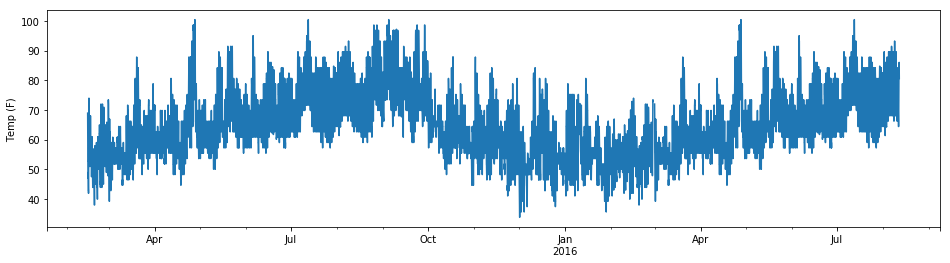

In [24]:
# pull normalized TMY3 temperature data over a range - make sure to use tz-aware datetimes!
start = datetime.datetime(2015, 2, 15, tzinfo=pytz.UTC)
end = datetime.datetime(2016, 8, 12, tzinfo=pytz.UTC)
temp_C = station.load_tmy3_hourly_temp_data(start, end)
temp_F = temp_C * 1.8 + 32  # convert from Celsius to Fahrenheit
ax = temp_F.plot(figsize=(16,4))
ax.set_ylabel('Temp (F)')
plt.show()

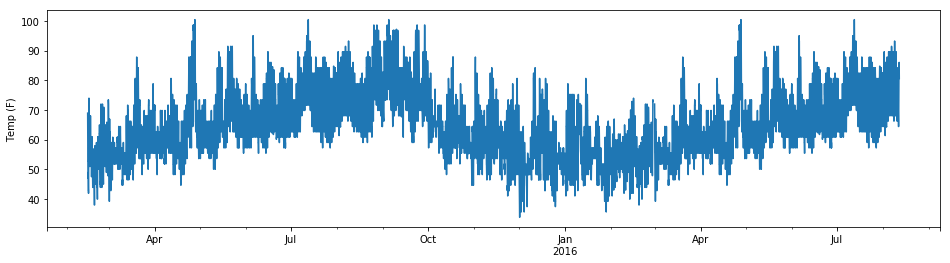

In [25]:
# pull normalized CZ2010 temperature data over a range - make sure to use tz-aware datetimes!
start = datetime.datetime(2015, 2, 15, tzinfo=pytz.UTC)
end = datetime.datetime(2016, 8, 12, tzinfo=pytz.UTC)
temp_C = station.load_cz2010_hourly_temp_data(start, end)
temp_F = temp_C * 1.8 + 32  # convert from Celsius to Fahrenheit
ax = temp_F.plot(figsize=(16,4))
ax.set_ylabel('Temp (F)')
plt.show()

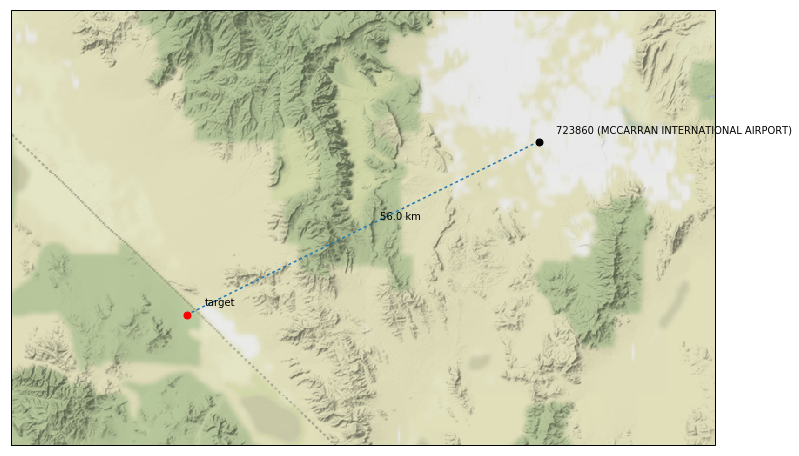

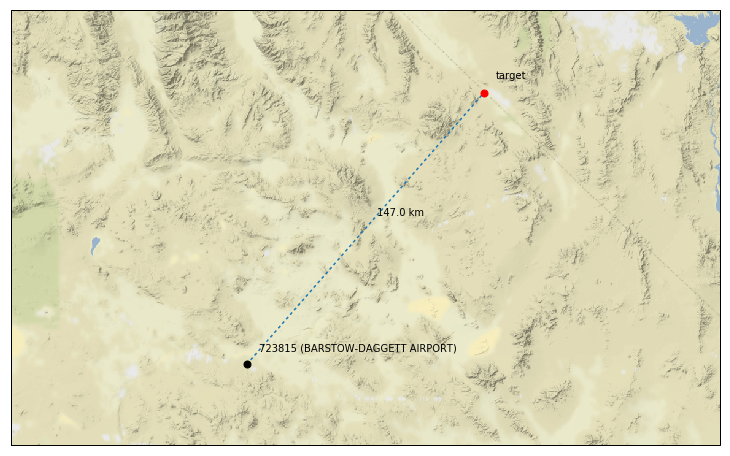

In [15]:
# use alternative mappings
from eeweather.mappings import oee_lat_long_tmy3, oee_lat_long_cz2010

# coordinates are on the California border to show difference in mapping results
lat, long = (35.85, -115.72)

# oee_lat_lng_tmy3 maps to stations that contain TMY3 data
result = eeweather.match_lat_long(lat, long, mapping=oee_lat_long_tmy3)
result.plot()

# oee_lat_lng_cz2010 maps to stations that contain CZ2010 data 
# CZ2010 stations are only inside California. This forces the location to be mapped
# to a slightly farther away weather station than when using the TMY3 mapping.
result = eeweather.match_lat_long(lat, long, mapping=oee_lat_long_cz2010)
result.plot()